In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.stem.snowball import SnowballStemmer
from scipy.stats.stats import pearsonr
from nltk.corpus import stopwords

%matplotlib inline

stemmer = SnowballStemmer('english')
printable = set(string.printable)
stop_words = set(stopwords.words('english'))

#Load data

In [2]:
attributes = pd.read_csv('data/attributes.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
description = pd.read_csv('data/product_descriptions.csv')

Distribution of target value in train set 

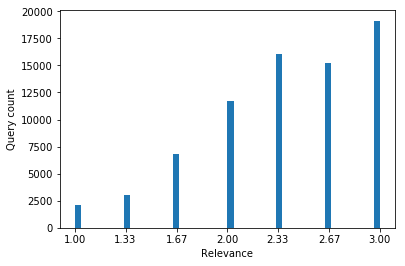

In [17]:
plt.hist(train['relevance'].tolist(), bins=50)
plt.xticks([1.00, 1.33, 1.67, 2.00, 2.33, 2.67, 3.00])
plt.xlabel('Relevance')
plt.ylabel('Query count')
plt.show()

In [18]:
print train['relevance'].value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64


Values [1.25, 1.50, 1.75, 2.25, 2.50, 2.75] are anomalies and should be deleted.

In [34]:
mask = np.logical_not(train['relevance'].isin([1.25, 1.50, 1.75, 2.25, 2.50, 2.75])).tolist()
train = train[mask]

In [78]:
#save updated train set
train.to_csv('data/train.csv')

Rest values [1.00, 1.33, 1.67, 2.00, 2.33, 2.67, 3.00] is [3, 4, 5, 6, 7, 8, 9] divided by 3. So it's sum of scores in range [1,3] from exactly 3 experts.

#Train and test sets

Count of unique product ids

In [43]:
print "All product ids count is ", description.shape[0]
print "Train: ", len(train['product_uid'].unique()), " unique product ids in ", train.shape[0], "rows."
print "Test: ", len(test['product_uid'].unique()), " unique product ids in ", test.shape[0], "rows."

All product ids count is  124428
Train:  54635  unique product ids in  74008 rows.
Test:  97460  unique product ids in  166693 rows.


Each product apears in average 1 search query in train set and in average 2 search queries in test set.

Count of words in queries

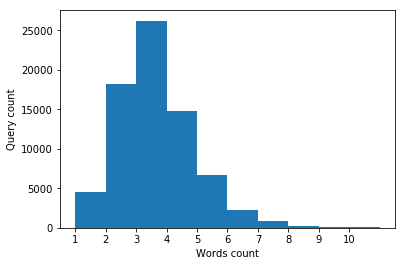

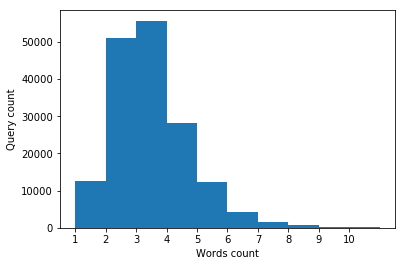

In [42]:
plt.hist([len(nltk.word_tokenize(line)) for line in train['search_term']], bins=10, range=(1, 11))
plt.xticks(range(1, 11, 1))
plt.xlabel('Words count')
plt.ylabel('Query count')
plt.show()

plt.hist([len(nltk.word_tokenize(line)) for line in test['search_term']], bins=10, range=(1, 11))
plt.xticks(range(1, 11, 1))
plt.xlabel('Words count')
plt.ylabel('Query count')
plt.show()

Distributions looks same. Most search queries contain no more than 4 words.

#Description set

Some descriptions contains part of html-code in the end. Let's find and delete that code.

In [3]:
count = 0

for i in range(len(description)):
     pos = description['product_description'][i].find("<")
     if pos != -1:
         count += 1
         description['product_description'][i] = description['product_description'][i][:pos]
         
print count

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


252


We successfully delete html-code in 252 descriptions. 

In [ ]:
#save updated dataframe
description.to_csv('data/product_descriptions.csv')

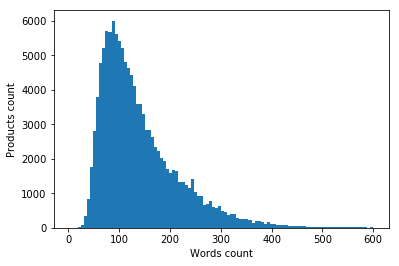

In [51]:
plt.hist([len(nltk.word_tokenize(line)) for line in description['product_description']], bins=100, range=(1,600))
plt.xlabel('Words count')
plt.ylabel('Products count')
plt.show()

Each description has in average 120-150 words.

#Attributes set

In [53]:
print "We have ", attributes.shape[0], " attributes for ", len(attributes['product_uid'].unique()), " different products."

We have  2044803  attributes for  86264  different products.


Most frequency attributes

In [79]:
most_freq_attributes = attributes['name'].value_counts()

print most_freq_attributes.head(20)

MFG Brand Name                 86250
Bullet02                       86248
Bullet03                       86226
Bullet04                       86174
Bullet01                       85940
Product Width (in.)            61137
Bullet05                       60529
Product Height (in.)           54698
Product Depth (in.)            53652
Product Weight (lb.)           45175
Bullet06                       44901
Color Family                   41508
Bullet07                       34349
Material                       31500
Color/Finish                   28564
Bullet08                       26645
Certifications and Listings    24583
Bullet09                       20567
Assembled Height (in.)         18299
Assembled Width (in.)          18263
Name: name, dtype: int64


From relevance instruction we know that finding brand in search term is very important.

In [61]:
print "Each product has no more than one brand name:", len(attributes[attributes.name == "MFG Brand Name"].product_uid.unique()) == \
      attributes[attributes.name == "MFG Brand Name"].shape[0]

Each product has no more than one brand name:

 True


In [66]:
print "We have brand name for 86250 products from ", description.shape[0], "(", round(86250.0 / description.shape[0] * 100, 1), "%)"

We have brand name for 86250 products from  124428 ( 69.3 %)


In [67]:
print "There are ", len(attributes[attributes.name == "MFG Brand Name"].value.unique()), " different brand names."

There are 

 4290  different brand names.


Look at attributes with name BulletXX.

In [71]:
mask = map(lambda x: bool(str(x).find("Bullet") != -1), attributes['name'])
print attributes[mask].name.value_counts()

Bullet02        86248
Bullet03        86226
Bullet04        86174
Bullet01        85940
Bullet05        60529
Bullet06        44901
Bullet07        34349
Bullet08        26645
Bullet09        20567
Bullet10        14763
Bullet11        11784
Bullet12         8795
Bullet13         6348
Bullet14         3853
Bullet20         3120
Bullet15         2913
Bullet18         2859
Bullet16         1897
Bullet17         1069
Bullet21          486
Bullet19          286
Bullet22          163
Bullet Proof       52
Name: name, dtype: int64


Each value contains some information of product like as product_description. But we should use this attributes with caution, because experts can't looked at any attributions.

Attributes for size

In [75]:
mask = map(lambda x: bool(str(x).find("Width") != -1 or str(x).find("Height") != -1 
                          or str(x).find("Depth") != -1 or str(x).find("Length") != -1), attributes['name'])
print attributes[mask].name.value_counts().head(10)

Product Width (in.)                   61137
Product Height (in.)                  54698
Product Depth (in.)                   53652
Assembled Height (in.)                18299
Assembled Width (in.)                 18263
Assembled Depth (in.)                 18198
Product Length (in.)                  16705
Product Length (ft.)                   2241
Cord Length (ft.)                      1437
Cut-Out Left to Right Length (in.)     1410
Name: name, dtype: int64


Attributes for color

In [76]:
mask = map(lambda x: bool(str(x).find("Color") != -1 or str(x).find("color") != -1), attributes['name'])
print attributes[mask].name.value_counts().head(10)

Color Family                    41508
Color/Finish                    28564
Color                            6222
Color/Finish Family              4630
Fixture Color/Finish             4119
Fixture Color/Finish Family      2256
Shade Color Family               2006
Actual Color Temperature (K)     1421
Color Rendering Index            1118
Top Color Family                  996
Name: name, dtype: int64


Attributes for material

In [77]:
mask = map(lambda x: bool(str(x).find("Material") != -1 or str(x).find("material") != -1), attributes['name'])
print attributes[mask].name.value_counts().head(10)

Material                       31500
Frame Material                  2376
Tile Material                   1679
Compatible Pipe Material        1674
Fastener/Connector Material     1586
Paint/Stain Base Material       1557
Housing Material                1500
Rug Material                    1111
Backing material                1101
Handle Material                 1086
Name: name, dtype: int64
